<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Building a few autoencoder models for practice sake**

In [ ]:
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

TensorFlow version: 2.2.0
Is Executing Eagerly? True


# Getting Data

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Train: X=(60000, 28, 28)
Test: X=(10000, 28, 28)


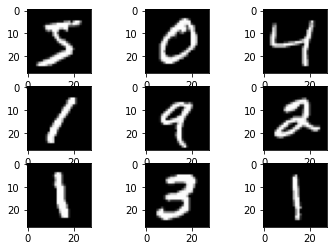

In [ ]:
# example of loading the mnist dataset
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X={}'.format(trainX.shape))
print('Test: X={}'.format(testX.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Autoencoder Model

In [ ]:
#from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
#from keras.models import Model
#from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.1097 - auc: 0.9883 - val_loss: 0.1108 - val_auc: 0.9883
Epoch 2/10
60000/60000 [==============================] - 14s 234us/step - loss: 0.1092 - auc: 0.9882 - val_loss: 0.1110 - val_auc: 0.9883
Epoch 3/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.1086 - auc: 0.9883 - val_loss: 0.1059 - val_auc: 0.9884
Epoch 4/10
60000/60000 [==============================] - 14s 235us/step - loss: 0.1080 - auc: 0.9885 - val_loss: 0.1042 - val_auc: 0.9885
Epoch 5/10
60000/60000 [==============================] - 14s 237us/step - loss: 0.1075 - auc: 0.9885 - val_loss: 0.1050 - val_auc: 0.9886
Epoch 6/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.1069 - auc: 0.9886 - val_loss: 0.1027 - val_auc: 0.9886
Epoch 7/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.1065 - auc: 0.9887 - val_loss: 0.

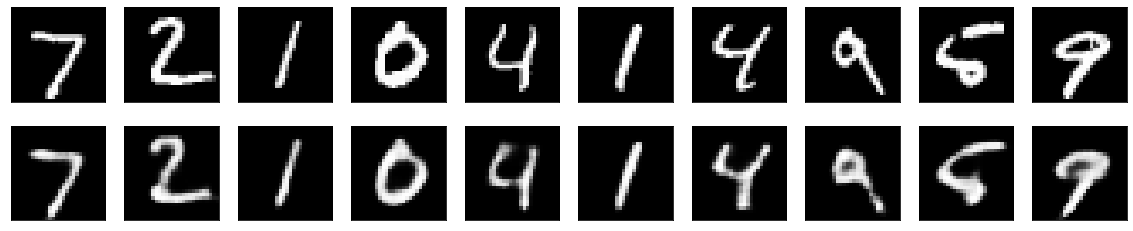

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

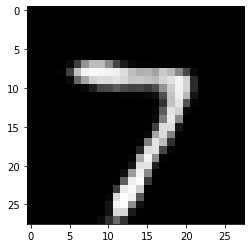

In [ ]:
# you can now display an image to see it is reconstructed well
x =decoded_imgs[0].reshape(28,28)
plt.imshow(x)

# Sandbox

In [ ]:
#Alternative way to prep data transforming mnist images into the tf,dataset
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

In [ ]:
#IF you want to save the model
model_json = ae.to_json()
with open("model_tex.json", "w") as json_file:
    json_file.write(model_json)

ae.save_weights("model_tex.h5")
print("Saved model"

# Other Autoencoder Models

In [ ]:
#ENCODER
inp = Input((28, 28,1))
e = Conv2D(32, (3, 3), activation='relu')(inp)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
l = Flatten()(e)
l = Dense(49, activation='softmax')(l)
#DECODER
d = Reshape((7,7,1))(l)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
ae = Model(inp, decoded)
ae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0   

In [ ]:
# compile it using adam optimizer
ae.compile(optimizer="adam", loss="mse")
#Train it by providing training images
#ae.fit(train_images, train_labels, epochs=2)
ae.fit(train_images, train_images, epochs=2)

Epoch 1/2
60000/60000 [==============================] - 402s 7ms/step - loss: 0.0089
Epoch 2/2
60000/60000 [==============================] - 392s 7ms/step - loss: 0.0080


In [ ]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    #conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv3) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

input_img = Input(shape=(28, 28, 1))  

auto_enc = Model(input_img, autoencoder(input_img))
auto_enc.summary()    

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0   